In [3]:
import yaml
import torch
import os
import json
import math
import numpy as np
import logging
from datetime import datetime, timedelta
from functools import partial
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from pathlib import Path
from skimage import io
from models.Storm import Storm
from scipy.sparse import csr_matrix
from tqdm import tqdm
import time
#from numba import njit, prange
import warnings
import itertools
import gc
import multiprocessing
from contextlib import contextmanager
import pandas as pd
import socket
import fcntl
import random
device = "cpu"
# Reset dict key as class attribute
class AttrDict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

def get_encoder(config_path, ckpt_path, device='cpu'):
    # load config
    with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    # to attribute
    model_config = AttrDict(config['model'])

    # build model
    model = Storm(model_config)

    # load ckpt
    state_dict = torch.load(ckpt_path, map_location="cpu")["base_model"]
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=True)

    # set eval mode & to GPU
    model.eval()
    model.to(device)
    return model

def get_embedding_RGB(config_path, ckpt_path,rgb,res,device="cpu"):
    model = get_encoder(config_path, ckpt_path, device=device)
    res = res.to(device).unsqueeze(0).unsqueeze(0)
    rgb = rgb.to(device).permute(0, 3, 1, 2)
    all_embedding = model.forward_rgb(rgb,res)
    return all_embedding

def get_embedding_all(config_path, ckpt_path,rgb,expr,res,device="cpu"):
    """
    rgb :batchsize 224 224 3
    expr: batchsize 56 56 15757
    """
    model = get_encoder(config_path, ckpt_path, device=device)
    res = res.to(device).unsqueeze(0).unsqueeze(0)
    rgb = rgb.to(device).permute(0, 3, 1, 2)
    expr = expr.to(device).permute(0, 3, 1, 2)

    all_embedding = model.forward_all(rgb,expr,res)
    return all_embedding



def get_expr(config_path, ckpt_path,rgb,res,device="cpu"):
    model = get_encoder(config_path, ckpt_path, device=device)
    res = res.to(device).unsqueeze(0).unsqueeze(0)
    rgb = rgb.to(device).permute(0, 3, 1, 2)
    expr = model.forward_rgb_to_expr(rgb, res)
    return expr

In [7]:
tif_sample = "posX_15_posY_25_B1587400-1_HE.tif"
expr_sample = "posX_15_posY_25_B1587400-1_expr.pt"
img = io.imread(tif_sample)
rgb = torch.from_numpy(img).float().unsqueeze(0)
expr = torch.load(expr_sample, weights_only=True)#.unsqueeze(0)
res = torch.full((1,), 0.5, dtype=torch.float32).unsqueeze(0)
config_path = "config.yaml"
ckpt_path = "STORM_hires.pth"
print("res",res)
print("expr",expr.shape)
print("rgb",rgb.shape)
expr = get_expr(config_path, ckpt_path,rgb,res)
print("get_expr",expr.shape)
all_embedding = get_embedding_all(config_path, ckpt_path,rgb,expr,res)
print("get_embedding_all",all_embedding.shape)
all_embedding = get_embedding_RGB(config_path, ckpt_path,rgb,res)
print("get_embedding_RGB",all_embedding.shape)

res tensor([[0.5000]])
expr torch.Size([3136, 15757])
rgb torch.Size([1, 224, 224, 3])


/tmp/ipykernel_294866/1723400002.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location="cpu")["base_model"]
/home/qinbw/STORM_

get_expr torch.Size([1, 56, 56, 15757])
get_embedding_all torch.Size([1, 392, 1024])
get_embedding_RGB torch.Size([1, 196, 1024])


/tmp/ipykernel_294866/295808386.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  expr_raw = torch.load(expr_sample, map_location="cpu")


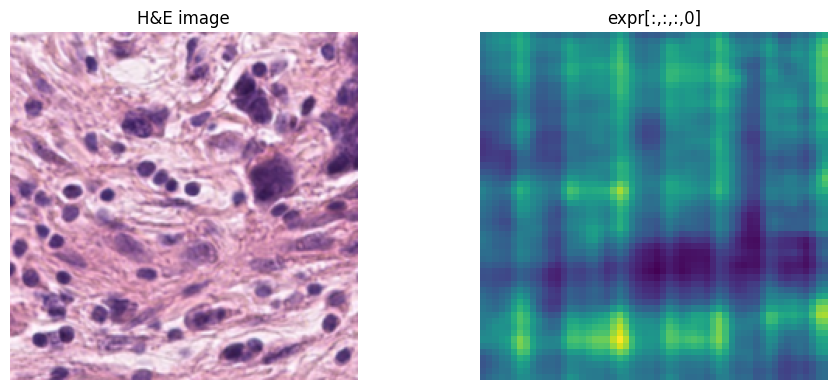

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.ndimage import gaussian_filter
# load data (reuse variables if already in session)
tif_sample = "posX_15_posY_25_B1587400-1_HE.tif"
expr_sample = "posX_15_posY_25_B1587400-1_expr.pt"

img = io.imread(tif_sample)
expr_raw = torch.load(expr_sample, map_location="cpu")
expr_map = expr[0, :, :,100].detach().cpu().numpy()
expr_smooth = gaussian_filter(expr_map, sigma=1.0)
expr_smooth = (expr_smooth - expr_smooth.min()) / (
    expr_smooth.max() - expr_smooth.min() + 1e-8
)


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("H&E image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(expr_smooth)
plt.title("expr[:,:,:,0]")
plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
import os
import re
import torch
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
from skimage import io

# === 参数设置 ===
tile_dir = "tiles"
config_path = "config.yaml"
ckpt_path = "STORM_hires.pth"
output_dir = "OC_Xenium_public"
#tile_dir = "/lustre1/zxzeng/bwqin/STORM/TCGA_tiles_0_5/CESC/TCGA-2W-A8YY"
#config_path = "large_ddp_rpb_lowres_benchmark.yaml"
#ckpt_path = "STORM_lowres.pth"
#gene_map_csv = "expr_get_embedding_Tumor.csv"
parser = argparse.ArgumentParser(description="Process gene map CSV.")
parser.add_argument(
    "--gene_map_csv",
    type=str,
    default="gene_token_homologs.csv"
)

args, unknown = parser.parse_known_args()

gene_map_csv = args.gene_map_csv
print("gene_map_csv =", gene_map_csv)

gene_map_csv = gene_token_homologs.csv


In [11]:
import os
import re
import torch
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
from skimage import io

# === 参数设置 ===
tile_dir = "tiles"
config_path = "config.yaml"
ckpt_path = "STORM_hires.pth"
output_dir = "OC_Xenium_public"
#tile_dir = "/lustre1/zxzeng/bwqin/STORM/TCGA_tiles_0_5/CESC/TCGA-2W-A8YY"
#config_path = "large_ddp_rpb_lowres_benchmark.yaml"
#ckpt_path = "STORM_lowres.pth"
#gene_map_csv = "expr_get_embedding_Tumor.csv"
parser = argparse.ArgumentParser(description="Process gene map CSV.")
parser.add_argument(
    "--gene_map_csv",
    type=str,
    default="gene_token_homologs.csv"
)

args, unknown = parser.parse_known_args()

gene_map_csv = args.gene_map_csv
print(f"Using gene map file: {gene_map_csv}")
batch_size = 128
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
#Use cpu only; with lowest memory 48G for batchsize 128 
select_genes = ["EPCAM"]
# === 加载 gene 对应维度 ===
gene_df = pd.read_csv(gene_map_csv)
gene_df = gene_df[gene_df["HGNC_symbol"].isin(select_genes)]
gene_to_idx = dict(zip(gene_df["HGNC_symbol"], gene_df.iloc[:, 0].astype(int)))
selected_genes = list(gene_to_idx.keys())
selected_indices = list(gene_to_idx.values())

# === 初始化模型 ===
def get_encoder(config_path, ckpt_path, device='cpu'):
    import yaml
    from models.Storm import Storm
    class AttrDict(dict):
        def __getattr__(self, name):
            return self[name]
    with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    model = Storm(AttrDict(config['model']))
    state_dict = torch.load(ckpt_path, map_location="cpu")["base_model"]
    model.load_state_dict(state_dict, strict=True)
    model.eval().to(device)
    return model

model = get_encoder(config_path, ckpt_path, device)

# === 批处理表达提取函数 ===
def get_expr_batch(model, rgb_batch, res_batch):
    rgb_batch = rgb_batch.to(device).permute(0, 3, 1, 2)
    res_batch = res_batch.to(device).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    with torch.no_grad():
        expr_batch = model.forward_rgb_to_expr(rgb_batch, res_batch)
    #print("expr_batch.shape",expr_batch.shape)
    return expr_batch[..., selected_indices].cpu()  # 只保留所需维度

# === 初始化输出结构 ===
os.makedirs(output_dir, exist_ok=True)
gene_arrays = {g: [] for g in selected_genes}
coords = []

# === 扫描所有tile并推理 ===
tif_files = sorted([f for f in os.listdir(tile_dir) if f.endswith("_HE.tif")])
batch_rgb = []
batch_coords = []

for tif_file in tqdm(tif_files, desc="Processing tiles"):
    match = re.search(r'posX_(\d+)_posY_(\d+)_', tif_file)
    if not match:
        continue
    x, y = int(match.group(1)), int(match.group(2))
    rgb = io.imread(os.path.join(tile_dir, tif_file)).astype("float32")
    img = torch.from_numpy(rgb).float() / 255.0 if rgb.max() > 1 else torch.from_numpy(rgb).float()
    batch_rgb.append(img)
    batch_coords.append((x, y))

    if len(batch_rgb) == batch_size:
        rgb_batch = torch.stack(batch_rgb)
        res_batch = torch.full((len(rgb_batch),), 0.5, dtype=torch.float32)
        expr_batch = get_expr_batch(model, rgb_batch, res_batch)  # [B, G, 56, 56]
        for i in range(expr_batch.shape[0]):
            for g, idx in zip(selected_genes, range(len(selected_genes))):
                gene_arrays[g].append(expr_batch[i,:,:,idx].unsqueeze(-1).numpy())
        coords.extend(batch_coords)
        batch_rgb, batch_coords = [], []

# === 处理最后一个batch ===
if batch_rgb:
    rgb_batch = torch.stack(batch_rgb)
    res_batch = torch.full((len(rgb_batch),), 0.5, dtype=torch.float32)
    expr_batch = get_expr_batch(model, rgb_batch, res_batch)
    for i in range(expr_batch.shape[0]):
        for g, idx in zip(selected_genes, range(len(selected_genes))):
            gene_arrays[g].append(expr_batch[i,:,:,idx].unsqueeze(-1).numpy())
    coords.extend(batch_coords)

# === 保存结果 ===
for g in selected_genes:
    arr = np.stack(gene_arrays[g], axis=0)  # [tile_num, 56, 56, 1]
    with open(os.path.join(output_dir, f"{g}.pkl"), "wb") as f:
        pickle.dump(arr, f)

with open(os.path.join(output_dir, "coords.pkl"), "wb") as f:
    pickle.dump(coords, f)

print(f"✅ Done. Saved to: {output_dir}")

Using gene map file: gene_token_homologs.csv


/tmp/ipykernel_296266/1776368456.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location="cpu")["base_model"]
Processing tiles: 

✅ Done. Saved to: OC_Xenium_public


In [13]:
epcam.shape

(8025, 56, 56, 1)

In [14]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import quantile_transform
from matplotlib.colors import LinearSegmentedColormap
from skimage.transform import resize
def quantile_normalize(arr, mask=None, n_quantiles=1000):
    arr_flat = arr.flatten()

    if mask is not None:
        mask_flat = mask.flatten()
        valid = arr_flat[mask_flat]
    else:
        valid = arr_flat[np.isfinite(arr_flat)]

    if len(valid) == 0:
        return np.zeros_like(arr)

    valid_reshaped = valid.reshape(-1, 1)
    normalized = quantile_transform(
        valid_reshaped,
        n_quantiles=min(n_quantiles, len(valid)),
        output_distribution="uniform",
        copy=True
    ).flatten()

    arr_out = arr.copy().flatten()
    if mask is not None:
        arr_out[mask_flat] = normalized
    else:
        arr_out[np.isfinite(arr_flat)] = normalized

    return arr_out.reshape(arr.shape)
vortex_cmap = LinearSegmentedColormap.from_list(
    "vortex_cmap",
    ["#3b0f70", "#1c6db7", "#4a8d6e", "#fdb863", "#a91e2c"]
)
vortex_cmap.set_under("black")

cmap = vortex_cmap
vmin, vmax = 0.01, 1.0

In [15]:
with open("OC_Xenium_public/EPCAM.pkl", "rb") as f:
    epcam = pickle.load(f)   # (N, 56, 56, 1)

with open("OC_Xenium_public/coords.pkl", "rb") as f:
    coords = pickle.load(f)

epcam = epcam[..., 0]  # (N, 56, 56)


In [18]:
xs = [c[0] for c in coords]
ys = [c[1] for c in coords]

max_x = max(xs)
max_y = max(ys)

H = (max_y + 1) * 56
W = (max_x + 1) * 56

slide = np.zeros((H, W), dtype=np.float32)
mask = np.zeros((H, W), dtype=bool)


In [19]:
for i, (x, y) in enumerate(coords):
    patch = epcam[i]  # (56, 56)
    y0 = y * 56
    x0 = x * 56

    slide[y0:y0+56, x0:x0+56] = patch
    mask[y0:y0+56, x0:x0+56] = True
slide_q = quantile_normalize(slide, mask=mask)
slide_q[~mask] = 0


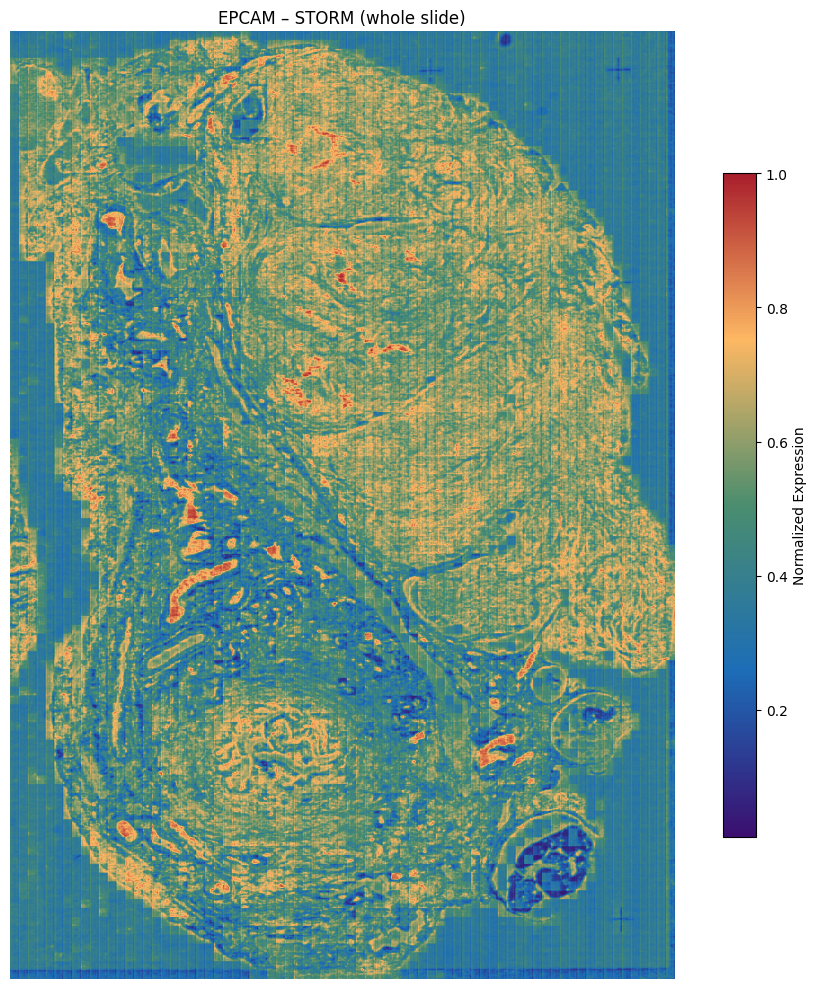

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(slide_q, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title("EPCAM – STORM (whole slide)")
plt.axis("off")
plt.colorbar(label="Normalized Expression", shrink=0.7)
plt.tight_layout()
plt.show()
